In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


               count          mean           std       min          25%  \
AveragePrice  9126.0  1.158040e+00  2.630406e-01      0.46       0.9800   
Total Volume  9126.0  1.653213e+06  4.747892e+06  33699.68  198908.6100   
4046          9126.0  5.786116e+05  1.742501e+06     72.06   31935.3800   
4225          9126.0  5.748053e+05  1.655582e+06   1518.00   50918.8500   
4770          9126.0  4.540580e+04  1.485750e+05      0.00     556.8800   
Total Bags    9126.0  4.543901e+05  1.358741e+06   3047.17   57247.9350   
Small Bags    9126.0  3.467218e+05  1.027420e+06   1119.18   43296.3225   
Large Bags    9126.0  1.014577e+05  3.374545e+05      0.00    2308.1075   
XLarge Bags   9126.0  6.210635e+03  2.463190e+04      0.00       0.0000   

                     50%           75%          max  
AveragePrice       1.130  1.320000e+00         2.22  
Total Volume  408325.530  1.030992e+06  62505646.52  
4046          104706.745  3.647169e+05  22743616.17  
4225          136114.740  4.15169

<ipython-input-206-1b09594f6a72>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  conventional = conventional.resample('W').mean()
<ipython-input-206-1b09594f6a72>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  organic = organic.resample('W').mean()


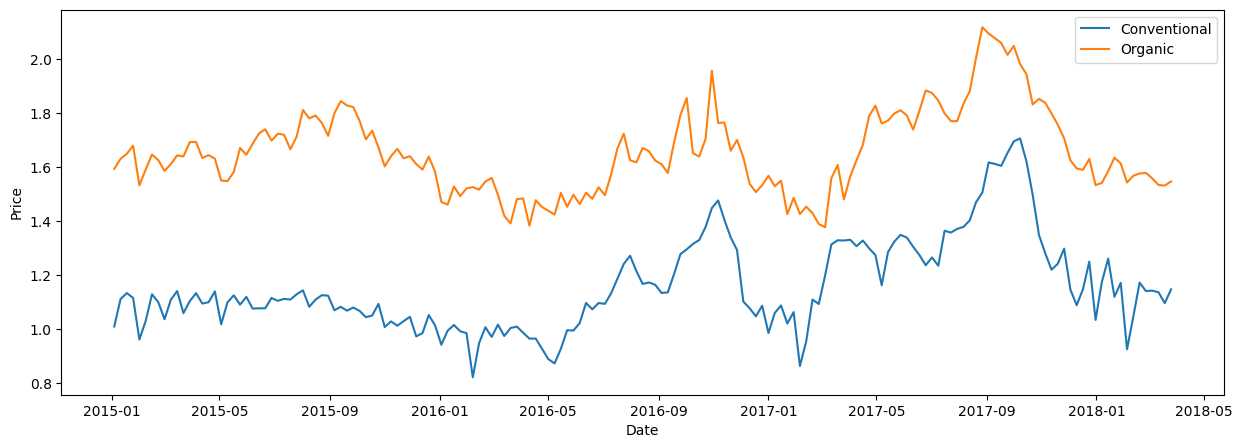

In [206]:
df = pd.read_csv('/content/drive/MyDrive/코딩/Avocado/avocado.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(['Unnamed: 0', 'year'], axis=1, inplace=True)
# onehot_region = pd.get_dummies(df['region'])
# df = pd.concat((df, onehot_region), axis=1)
# display(df)

conventional = df[df['type']=='conventional']
organic = df[df['type']=='organic']
conventional = conventional.drop('type', axis=1)
organic = organic.drop('type', axis=1)

conventional.sort_values(by='Date', axis=0, ascending=True, inplace=True)
organic.sort_values(by='Date', axis=0, ascending=True, inplace=True)

print(conventional.describe().T)
print(organic.describe().T)

conventional.set_index('Date', inplace=True)
conventional = conventional.resample('W').mean()
organic.set_index('Date', inplace=True)
organic = organic.resample('W').mean()

plt.figure(figsize=(15,5))
plt.plot(conventional['AveragePrice'])
plt.plot(organic['AveragePrice'])
plt.legend(['Conventional', 'Organic'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [222]:
import torch
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device
device = get_device()

conventional_x, conventional_y = conventional.drop(['AveragePrice'], axis=1).values, conventional['AveragePrice'].values
organic_x, organic_y = organic.drop(['AveragePrice'], axis=1).values, organic['AveragePrice'].values

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(conventional_x)
conventional_x = ss.transform(conventional_x)
ss = StandardScaler()
organic_x = ss.fit_transform(organic_x)

def sequence_data(x, y, sequence):
    x_sequence = []
    y_sequence = []
    for i in range(len(x)-sequence):
        x_sequence.append(x[i:i+sequence])
        y_sequence.append(y[i+sequence])
    return torch.Tensor(x_sequence).float().to(device), torch.Tensor(y_sequence).float().to(device).view([-1,1])

split = 20
sequence = 5
x_features = conventional_x.shape[1]
x_sequence_conventional, y_sequence_conventional = sequence_data(conventional_x, conventional_y, sequence)
x_sequence_organic, y_sequence_organic = sequence_data(organic_x, organic_y, sequence)
x_train_conventional, x_test_conventional, y_train_conventional, y_test_conventional = x_sequence_conventional[:-20], x_sequence_conventional[-20:], y_sequence_conventional[:-20], y_sequence_conventional[-20:]
x_train_organic, x_test_organic, y_train_organic, y_test_organic = x_sequence_organic[:-20], x_sequence_organic[-20:], y_sequence_organic[:-20], y_sequence_organic[-20:]

from torch.utils.data import TensorDataset, DataLoader
train_conv = TensorDataset(x_train_conventional, y_train_conventional)
test_conv = TensorDataset(x_test_conventional, y_test_conventional)
train_organ = TensorDataset(x_train_organic, y_train_organic)
test_organ = TensorDataset(x_test_organic, y_test_organic)

batch_size = 8
train_dl_conv = DataLoader(train_conv, batch_size=batch_size, shuffle=False)
test_dl_conv = DataLoader(test_conv, batch_size=batch_size, shuffle=False)
train_dl_organ = DataLoader(train_organ, batch_size=batch_size, shuffle=False)
test_dl_organ = DataLoader(test_organ, batch_size=batch_size, shuffle=False)

In [226]:
import torch.nn as nn
num_layers = 2
hidden_size = 8

class RNNModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence, device):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence = sequence
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * sequence, 1))

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out.reshape(out.shape[0],-1))
        return out

model = RNNModule(x_features, hidden_size, num_layers, sequence, device).to(device)

num_epochs = 300
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-03)
losses = []
testloss = []
n = len(train_dl_conv)
m = len(test_dl_conv)
for epoch in range(num_epochs):
    running_loss = .0
    test_loss = .0
    for data in train_dl_conv:
        x, y = data
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
    for data in test_dl_conv:
        x, y = data
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        test_loss += loss.item()
    losses.append(running_loss/n)
    testloss.append(test_loss/m)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}\nTrain_Loss: {running_loss/n:.4f} Test_Loss: {test_loss/m:.4f}')

Epoch: 000
Train_Loss: 1.2704 Test_Loss: 0.8909
Epoch: 010
Train_Loss: 0.0820 Test_Loss: 0.1214
Epoch: 020
Train_Loss: 0.0724 Test_Loss: 0.0922
Epoch: 030
Train_Loss: 0.0855 Test_Loss: 0.0740
Epoch: 040
Train_Loss: 0.0773 Test_Loss: 0.0742
Epoch: 050
Train_Loss: 0.0928 Test_Loss: 0.1064
Epoch: 060
Train_Loss: 0.0629 Test_Loss: 0.0868
Epoch: 070
Train_Loss: 0.0769 Test_Loss: 0.0611
Epoch: 080
Train_Loss: 0.0723 Test_Loss: 0.0744
Epoch: 090
Train_Loss: 0.0604 Test_Loss: 0.0943
Epoch: 100
Train_Loss: 0.0682 Test_Loss: 0.0572
Epoch: 110
Train_Loss: 0.0540 Test_Loss: 0.0766
Epoch: 120
Train_Loss: 0.0561 Test_Loss: 0.0621
Epoch: 130
Train_Loss: 0.0632 Test_Loss: 0.1052
Epoch: 140
Train_Loss: 0.0617 Test_Loss: 0.0706
Epoch: 150
Train_Loss: 0.0784 Test_Loss: 0.0533
Epoch: 160
Train_Loss: 0.0432 Test_Loss: 0.0507
Epoch: 170
Train_Loss: 0.0434 Test_Loss: 0.0545
Epoch: 180
Train_Loss: 0.0448 Test_Loss: 0.0511
Epoch: 190
Train_Loss: 0.0511 Test_Loss: 0.0564
Epoch: 200
Train_Loss: 0.1044 Test_Loss:

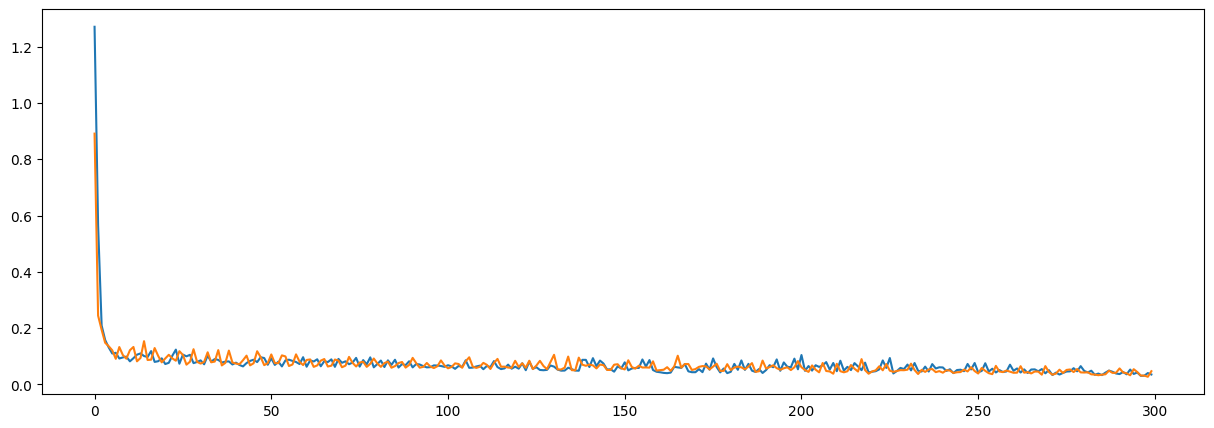

In [227]:
plt.figure(figsize=(15,5))
plt.plot(losses)
plt.plot(testloss)
plt.show()

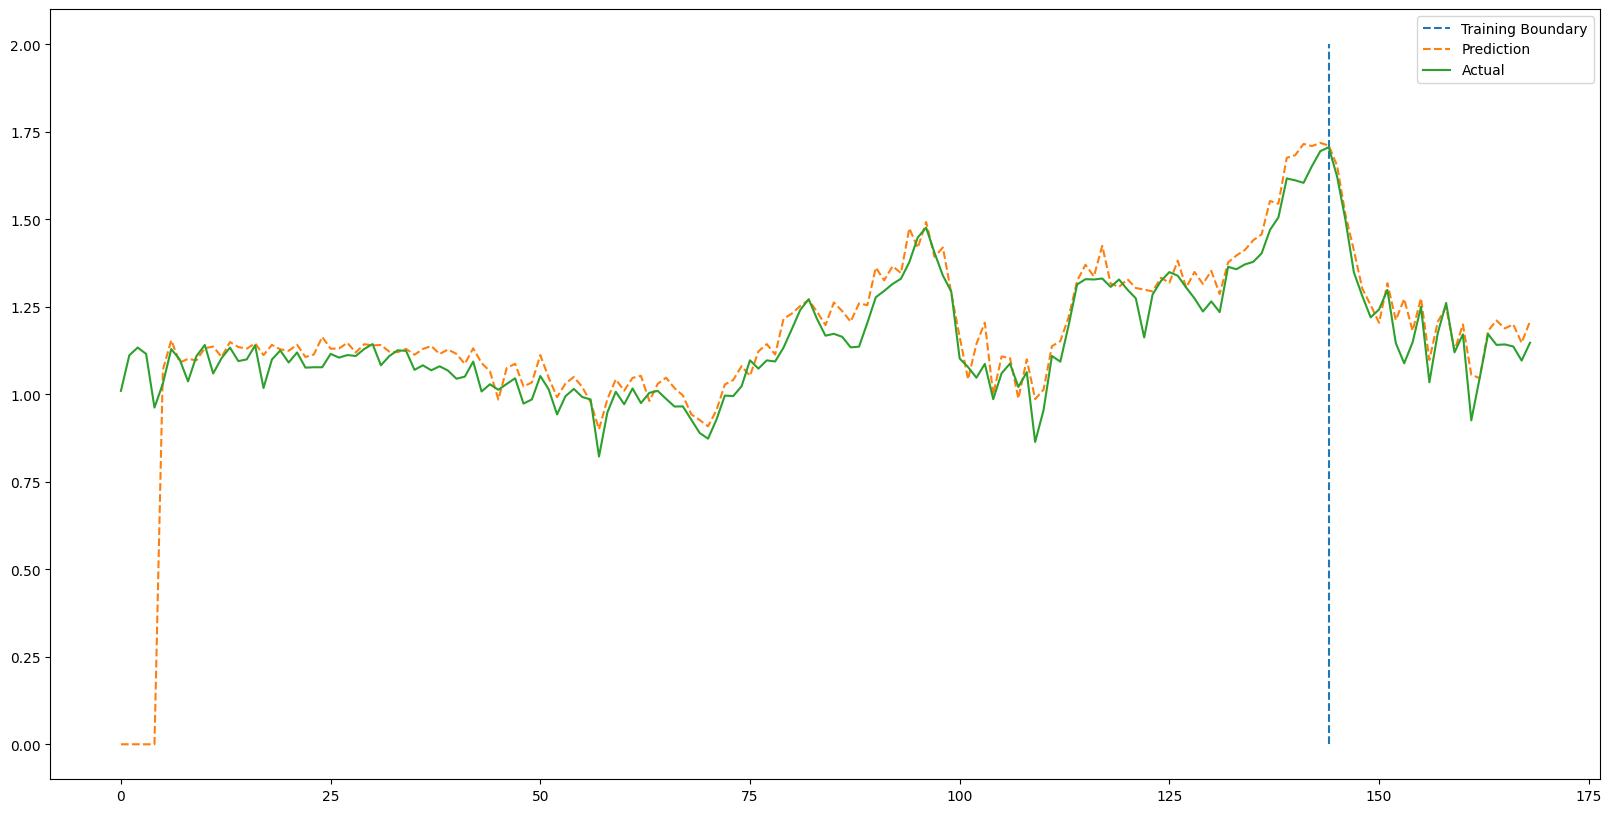

In [228]:
def plotting(train_dl, test_dl, real):
    with torch.no_grad():
        train_pred = []
        test_pred = []
        for data in train_dl:
            x, y = data
            pred = model(x)
            train_pred += pred.cpu().numpy().tolist()
        for data in test_dl:
            x, y = data
            pred = model(x)
            test_pred += pred.cpu().numpy().tolist()
    total_pred = [[0]]*sequence + train_pred + test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0,2,100), '--')
    plt.plot(total_pred, '--')
    plt.plot(real)
    plt.legend(['Training Boundary', 'Prediction', 'Actual'])
    plt.show()
real_value = conventional['AveragePrice'].reset_index().drop('Date', axis=1)
plotting(train_dl_conv, test_dl_conv, real_value)